<a href="https://colab.research.google.com/github/MdNiamul/DataHioding/blob/main/Accoury_15_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Run first (installs quietly)
!pip install pillow matplotlib numpy scipy --quiet
print("Dependencies installed.")


Dependencies installed.


Upload one image (cover or suspect).


Saving 136071848_2776442649240267_2961728220654727664_n.jpg to 136071848_2776442649240267_2961728220654727664_n (1).jpg
Loaded: 136071848_2776442649240267_2961728220654727664_n (1).jpg


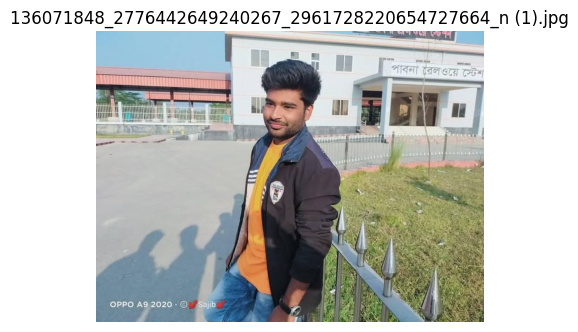


--- Metrics ---
LSB mean (fraction of ones): 0.50078
LSB entropy: 1.00000
Chi-like value (even/odd hist test): 5011.87

PVD-related (neighbors diffs):
  prop diffs ≤1: 43.578%
  prop diffs in [2..8]: 31.994%
  mid/small ratio (2..8)/(≤1): 0.734
  mean diff: 7.316, var diff: 171.135

--- Heuristic confidences ---
LSB-likelihood score: 91.5%
PVD-likelihood score: 85.8%

=== SUMMARY ===
Decision: SUSPICIOUS (ambiguous: LSB or PVD possible)
LSB score: 91.5%, PVD score: 85.8%
Notes:
- LSB score uses LSB mean closeness to 0.5, LSB entropy, and chi-like even/odd histogram test.
- PVD score uses neighbor-differences distribution (mid-range vs small-range).
- These are heuristics — compression, resizing, or image editing can change results.



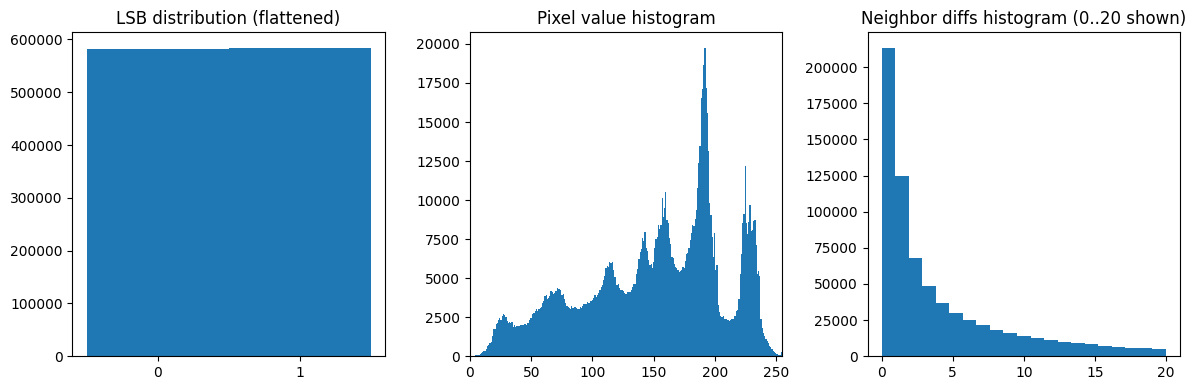

In [11]:
from google.colab import files
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid

# ---------- Upload ----------
print("Upload one image (cover or suspect).")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")

fname = list(uploaded.keys())[0]
img = Image.open(io.BytesIO(uploaded[fname])).convert("RGB")
print("Loaded:", fname)
plt.figure(figsize=(5,5)); plt.imshow(img); plt.axis('off'); plt.title(fname); plt.show()

# ---------- Helpers ----------
def lsb_metrics(pil_img):
    arr = np.array(pil_img)
    lsb = arr & 1
    total = lsb.size
    ones = int(lsb.sum())
    zeros = int(total - ones)
    mean = ones / total
    # entropy of LSB distribution
    p0 = zeros / total
    p1 = ones / total
    import math
    ent = - (p0*math.log2(p0+1e-12) + p1*math.log2(p1+1e-12))
    return {
        "mean": float(mean),
        "ones": ones,
        "zeros": zeros,
        "total_bits": int(total),
        "entropy": float(ent),
        "lsb_map": lsb
    }

def chi_square_lsb_like(pil_img):
    # Chi-like between even/odd pixel value frequencies (global)
    arr = np.array(pil_img)
    vals = arr.ravel()
    hist, _ = np.histogram(vals, bins=256, range=(0,255))
    even = hist[::2].astype(np.float64)
    odd  = hist[1::2].astype(np.float64)
    denom = even + odd
    denom[denom == 0] = 1e-6
    chi = np.sum((even - odd)**2 / denom)
    return float(chi)

def pvd_metrics(pil_img):
    # Compute absolute neighbor differences (grayscale) horizontally+vertically
    gray = np.array(pil_img.convert("L"), dtype=np.int16)
    h_diff = np.abs(gray[:,1:] - gray[:,:-1]).ravel()
    v_diff = np.abs(gray[1:,:] - gray[:-1,:]).ravel()
    diffs = np.concatenate([h_diff, v_diff])
    total = diffs.size
    # proportions
    prop_eq0 = np.sum(diffs==0)/total
    prop_le1  = np.sum(diffs<=1)/total
    prop_2_8  = np.sum((diffs>=2) & (diffs<=8))/total
    prop_gt8  = np.sum(diffs>8)/total
    mean = float(diffs.mean())
    var  = float(diffs.var())
    # ratio indicator: mid-range / small-range
    mid_small_ratio = (prop_2_8) / (prop_le1 + 1e-12)
    return {
        "total_diffs": int(total),
        "prop_eq0": float(prop_eq0),
        "prop_le1": float(prop_le1),
        "prop_2_8": float(prop_2_8),
        "prop_gt8": float(prop_gt8),
        "mean": mean,
        "var": var,
        "mid_small_ratio": float(mid_small_ratio),
        "diffs_hist": diffs  # raw for plotting if needed
    }

# ---------- Run metrics ----------
lsb = lsb_metrics(img)
chi = chi_square_lsb_like(img)
pvd = pvd_metrics(img)

print("\n--- Metrics ---")
print(f"LSB mean (fraction of ones): {lsb['mean']:.5f}")
print(f"LSB entropy: {lsb['entropy']:.5f}")
print(f"Chi-like value (even/odd hist test): {chi:.2f}")
print("\nPVD-related (neighbors diffs):")
print(f"  prop diffs ≤1: {pvd['prop_le1']*100:.3f}%")
print(f"  prop diffs in [2..8]: {pvd['prop_2_8']*100:.3f}%")
print(f"  mid/small ratio (2..8)/(≤1): {pvd['mid_small_ratio']:.3f}")
print(f"  mean diff: {pvd['mean']:.3f}, var diff: {pvd['var']:.3f}")

# ---------- Heuristic scoring ----------
# LSB score: combine closeness of mean to 0.5, high entropy (~1), chi small -> more suspicious
# score components 0..1
lsb_mean_score = 1 - abs(lsb['mean'] - 0.5)*4  # maps deviation -> [1..-?], centered. scale factor 4 to make 0.02 deviation important
lsb_mean_score = max(0.0, min(1.0, lsb_mean_score))

lsb_entropy_score = (lsb['entropy']) / 1.0  # entropy max ~1 for fair 2-bit
lsb_entropy_score = max(0.0, min(1.0, lsb_entropy_score))

# chi: smaller chi suggests LSB embedding in many heuristics — normalize using soft cutoff
chi_norm = 1/(1 + chi/1000.0)   # larger chi -> smaller score
chi_norm = max(0.0, min(1.0, chi_norm))

lsb_score = (lsb_mean_score*0.45 + lsb_entropy_score*0.45 + chi_norm*0.10)

# PVD score: use mid_small_ratio: higher ratio -> more PVD-like; also mean/var influence
ratio = pvd['mid_small_ratio']
# map ratio to 0..1 with sigmoid: center 0.5 -> adjust
pvd_score = float(expit((ratio - 0.5)*5.0))  # expit is sigmoid to make contrast
# small adjustment by mean/var (if mean large or var large, raise slightly)
pvd_score = pvd_score * (0.6) + (min(1.0, pvd['mean']/5.0))*0.4

# ---------- Final decision logic ----------
# If lsb_score >> pvd_score => likely LSB. If pvd_score >> lsb_score => likely PVD.
# If both low => likely clean/none
lsb_pct = lsb_score * 100
pvd_pct = pvd_score * 100

print("\n--- Heuristic confidences ---")
print(f"LSB-likelihood score: {lsb_pct:.1f}%")
print(f"PVD-likelihood score: {pvd_pct:.1f}%")

# Decide labels with margins
label = "UNCERTAIN / LIKELY CLEAN"
if lsb_score > 0.6 and lsb_score - pvd_score > 0.15:
    label = "LIKELY LSB stego"
elif pvd_score > 0.6 and pvd_score - lsb_score > 0.15:
    label = "LIKELY PVD stego"
elif max(lsb_score, pvd_score) > 0.5:
    # ambiguous but suspicious
    label = "SUSPICIOUS (ambiguous: LSB or PVD possible)"
else:
    label = "LIKELY CLEAN (no strong evidence)"

print("\n=== SUMMARY ===")
print(f"Decision: {label}")
print(f"LSB score: {lsb_pct:.1f}%, PVD score: {pvd_pct:.1f}%")
print("Notes:")
print("- LSB score uses LSB mean closeness to 0.5, LSB entropy, and chi-like even/odd histogram test.")
print("- PVD score uses neighbor-differences distribution (mid-range vs small-range).")
print("- These are heuristics — compression, resizing, or image editing can change results.\n")

# ---------- Visuals ----------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("LSB distribution (flattened)")
plt.hist(lsb['lsb_map'].ravel(), bins=[-0.5,0.5,1.5])
plt.xticks([0,1])
plt.subplot(1,3,2)
plt.title("Pixel value histogram")
plt.hist(np.array(img).ravel(), bins=256)
plt.xlim(0,255)
plt.subplot(1,3,3)
plt.title("Neighbor diffs histogram (0..20 shown)")
d = pvd['diffs_hist']
plt.hist(d[d<=20], bins=21)
plt.tight_layout()
plt.show()


In [3]:
!pip install pillow matplotlib numpy --quiet
print("Dependencies installed ✅")


Dependencies installed ✅


In [14]:
from google.colab import files
from PIL import Image
import io

print("Upload ORIGINAL image first:")
orig_uploaded = files.upload()
orig_fname = list(orig_uploaded.keys())[0]
original_img = Image.open(io.BytesIO(orig_uploaded[orig_fname])).convert("RGB")
print("Original loaded:", orig_fname)

print("\nUpload SUSPECT/ENCODED image:")
sus_uploaded = files.upload()
sus_fname = list(sus_uploaded.keys())[0]
suspect_img = Image.open(io.BytesIO(sus_uploaded[sus_fname])).convert("RGB")
print("Suspect loaded:", sus_fname)

# --- Resize suspect to match original if needed
if original_img.size != suspect_img.size:
    print(f"Resizing suspect {suspect_img.size} -> original {original_img.size}")
    suspect_img = suspect_img.resize(original_img.size)


Upload ORIGINAL image first:


Saving military_bengali_steganography_1756007317.png to military_bengali_steganography_1756007317 (3).png
Original loaded: military_bengali_steganography_1756007317 (3).png

Upload SUSPECT/ENCODED image:


Saving military_bengali_steganography_1756007317.png to military_bengali_steganography_1756007317 (4).png
Suspect loaded: military_bengali_steganography_1756007317 (4).png


====== STEGO DETECTION ======
Total bits: 1166400
LSB differing bits: 0 (0.000%)
MSB differing bits: 0 (0.000%)
Suspect LSB entropy: 1.0000
✅ LSB stego unlikely
✅ PVD unlikely

Detected method (likely): PVD or other


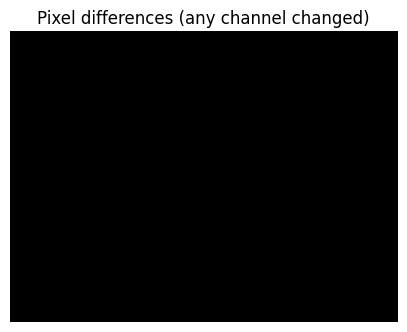

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def stego_detect(original_img, suspect_img):
    oarr = np.array(original_img)
    sarr = np.array(suspect_img)

    # --- LSB difference
    o_lsb = oarr & 1
    s_lsb = sarr & 1
    total_bits = o_lsb.size
    lsb_diff = np.sum(o_lsb != s_lsb)
    lsb_ratio = lsb_diff / total_bits * 100

    # --- PVD / MSB difference
    o_msb = (oarr >> 7) & 1
    s_msb = (sarr >> 7) & 1
    msb_diff = np.sum(o_msb != s_msb)
    msb_ratio = msb_diff / total_bits * 100

    # --- LSB entropy suspect
    zeros = np.sum(s_lsb==0)
    ones = np.sum(s_lsb==1)
    entropy = -( (zeros/total_bits)*np.log2(zeros/total_bits+1e-12) +
                 (ones/total_bits)*np.log2(ones/total_bits+1e-12) )

    # --- Decision logic
    print("====== STEGO DETECTION ======")
    print(f"Total bits: {total_bits}")
    print(f"LSB differing bits: {lsb_diff} ({lsb_ratio:.3f}%)")
    print(f"MSB differing bits: {msb_diff} ({msb_ratio:.3f}%)")
    print(f"Suspect LSB entropy: {entropy:.4f}")

    if lsb_ratio > 0.1:
        print("⚠️ LSB stego likely")
    else:
        print("✅ LSB stego unlikely")

    if msb_ratio > 0.5:
        print("⚠️ PVD or large pixel differences detected")
    else:
        print("✅ PVD unlikely")

    # Combined simple heuristic
    if lsb_ratio > msb_ratio:
        method = "LSB"
    else:
        method = "PVD or other"
    print(f"\nDetected method (likely): {method}")

    # Difference map
    diff_map = np.any(oarr != sarr, axis=2).astype(np.uint8) * 255
    plt.figure(figsize=(5,5))
    plt.title("Pixel differences (any channel changed)")
    plt.imshow(diff_map, cmap='gray')
    plt.axis("off")
    plt.show()

# --- Run
stego_detect(original_img, suspect_img)
